# 2. Linear Regression and Bias-Variance Tradeoff

### Linear Model 

In this notebook, we create a generalized linear model capable of running linear, logistic and perceptron regressions with polynomial kernels, standardized and normalized features with regularization. The linear regression can minimize Mean Squared Error (MSE), Mean Absolute Error (MAE) and Root Mean Square Error (RMSE). The logistic regression can work on Log Loss or Cross Entropy loss, Mean Squared Error (MSE) and Mean Absolute Error (MAE). The perceptron only works with a 0-1 loss function. Four Convergence procedures have also been implemented namely Batch Gradient Descent, Stochastic Gradient Descent, Newton's Method and Normal Equations. Newton's Method assumes mse loss for linear regression and log loss for logistic regression while Normal equations are only valued for mse loss for linear regression. 

### Linear Regression 

We then implement linear regression on the given dataset https://www.dropbox.com/s/8tqk3cavdbbe3nb/weather_data.xlsx?dl=0 with a few polynomial kernels and regularization coefficients in this notebook and with a cross-validation split and calculate their average test errors (mse loss, rmse loss, mae loss and r2 parameter) to predict temperature. An nth degree kernel implies that all higher degree features are present upto the nth degree. For eg., if a dataset contains three features (x1, x2 and x3), a second degree kernel will have (1, x1, x2, x3, x1^2, x2^2, x3^2, x1x2, x1x3, x2x3) and so on. The regularization coefficients decide which kind of regression will take place. If both l1_alpha and l2_alpha are zero, we have unregularized regression. If l1_alpha is non-zero and l2_alpha is zero, we have l1 regularization, and the resulting regression is called lasso regression. Similarly, if only l2_alpha is non-zero, we have ridge regression and elastic net when both are non-zero.

### Bias-Variance Tradeoff

Now, we have three hyperparameters of this general linear model (degree of polynomial kernel and the regularization coefficients). To find the Bias-Variance tradeoff curves, we vary the polynomial degree for a few combinations of regularization coefficients and save the training and test errors for a 80-20 train-test split in csv files. We assume that training errors would correspond to emperical risk while test errors would correspond to the real risk. We then plot the training errors and test errors as a function of model size (here polynomial kernel degree) for each regularization coefficient combination. The regularization coefficients each take discrete values of 0, 0.5 and 1 giving us a total of 9 combinations for each loss function and type of regression. Since we have 3 loss functions for linear regression, we get a total of 18 csv files each containing training and test errors across 4 metrics discussed above (mse error, mae error, rmse error and r2 squared score). We will attach graphs of the variation of these parameters with the model size for a few regularization coefficients in the report and discuss these further.

We also repeat the Bias-Variance tradeoff curves for logistic and perceptron regressions applied on the dataset of the first question: https://www.dropbox.com/s/t7ycfw00mc755cg/health_data.csv?dl=0. We have already seen how they perform on the classification tasks with respect to Accuracy, Precision, Specificity and F1 scores, but now we would see to what extent they are successful in reducing training and test errors. We plot the curves for these functions alongside those of linear reg

In [81]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import ErrorMetricsUtils as err
import CorrectnessMetricUtils as cmu
import AuxUtils as auxu
from csv import reader, writer
import random
import time
import os

#Lasso
class l1_regularization():
    def __init__(self, alpha):
        self.alpha = alpha
    def __call__(self, W):
        return self.alpha * np.linalg.norm(W)
    def grad(self, W):
        return self.alpha * np.sign(W)
#Ridge
class l2_regularization():
    def __init__(self, alpha):
        self.alpha = alpha
    def __call__(self, W):
        return self.alpha * 0.5 *  W.T@W
    def grad(self, W):
        return self.alpha * W

## Generalized Linear Model

Inputs the degree of the polynomial kernel, regularization coefficients, loss function (mse, mae, rmse, log, cross entropy, zero-one), model type (linear, perceptron or logistic), convergence type and other parameters to give a robust linear model

In [82]:
class LinearModel():  
    
    def __init__ (self, regression_degree = 5, l1_alpha = 0, l2_alpha = 0, loss = "mse", model_type = "linear", 
                  convergence = "Stochastic Gradiet Descent", include_bias = True, standardize = True, 
                  normalize = True, learning_type = "normalized", max_iter = 1e+4, learning_rate = 0.1, 
                  epsilon = 0.01, print_stuff = "prio"):
        self.l1_alpha = l1_alpha
        self.l2_alpha = l2_alpha
        self.loss = loss
        self.model_type = model_type
        self.convergence = convergence
        self.standardize = standardize
        self.normalize = normalize
        self.learning_type = learning_type
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.theta = []
        self.fitted = False
        self.print_stuff = print_stuff
        self.poly = auxu.PolynomialKernel(regression_degree, include_bias)
        if (self.model_type == "perceptron"):
            self.g = lambda x: np.piecewise(x, [x < 0, x >= 0], [0, 1])
        elif (self.model_type == "logistic"):
            self.g = lambda x: 1 / (1 + np.exp(-x))
        else:
            self.g = lambda x:x
            
    def init_theta (self, X_train):
        if (X_train.ndim == 1):
            X_train = X_train[None, :]
        if (self.standardize):
            X_train = auxu.standardize(X_train)
        if (self.normalize):
            X_train = auxu.normalize(X_train)
        Xk_train = self.poly.kernelize(X_train)
        self.theta = np.zeros(Xk_train.shape[1])
        return
    
    def repeat_fit (self, X_train, y_train):
        if (X_train.ndim == 1):
            X_train = X_train[None, :]
        if (self.standardize):
            X_train = auxu.standardize(X_train)
        if (self.normalize):
            X_train = auxu.normalize(X_train)
        Xk_train = self.poly.kernelize(X_train)
        if (not len(self.theta) == Xk_train.shape[1]):
            self.init_theta(X_train)
        self.call_convergence(Xk_train, y_train)
        self.fitted = True
        return
    
    def call_convergence (self, X, y):
        if (self.convergence == "Stochatic Gradient Descent"):
            self.sch_grad_descent (X, y)
        elif (self.convergence == "Normal Equations"):
            self.normal_eqn (X, y)
        elif (self.convergence == "Newton's Method"):
             self.newton_method (X, y)
        else:
            self.bch_grad_descent (X, y)
        return
    
    def change_degree (self, degree):
        self.poly.degree = degree
    
    # General linear model
    def fit (self, X_train, y_train):
        #X_train = np.asarray(X)
        #y_train = np.asarray(y)
        if (X_train.ndim == 1):
            X_train = X_train[None, :]
        if (self.standardize):
            X_train = auxu.standardize(X_train)
        if (self.normalize):
            X_train = auxu.normalize(X_train)
        Xk_train = self.poly.kernelize(X_train)
        self.theta = np.zeros(Xk_train.shape[1])
        self.call_convergence(Xk_train, y_train)
        self.fitted = True
        return self.theta
    
    def predict (self, X_test):
        #X_test = np.asarray(X)
        if (X_test.ndim == 1):
            X_test = X_test[None, :]
        if (self.standardize):
            X_test = auxu.standardize(X_test)
        if (self.normalize):
            X_test = auxu.normalize(X_test)
        Xk_test = self.poly.kernelize(X_test)
        if (self.check_fitted(Xk_test)): 
            return self.g(Xk_test @ self.theta)
        else: 
            # some error statement
            return -1 
    
    def log_predict (self, X_test):
        disc = self.predict (X_test)
        return np.piecewise(disc, [disc < 0.5, disc >= 0.5], [0, 1]) 
    
    def check_fitted (self, Xk_test):
        return self.fitted and self.theta.shape[0] == Xk_test.shape[1]
    
    def calc_loss (self, X, y):
        hypo = self.g (X @ self.theta)
        if (self.loss == "rmse"):
            return err.rmse_calc (y, hypo)
        elif (self.loss == "mae"):
            return err.mae_calc (y, hypo)
        elif (self.loss == "kld"):
            if (self.model_type == "logistic" or self.model_type == "perceptron"):
                return err.kl_divergence_calc (y, hypo)
            else:
                return float("Nan")
        elif (self.loss == "cross_entropy"):
            if (self.model_type == "logistic" or self.model_type == "perceptron"):
                return err.cross_entropy_calc (y, hypo)
            else:
                return float("Nan")
        else:
            # default case mse
            return err.mse_calc (y, hypo)
        
    def regularizer_neg_gradient(self):
        l1 = l1_regularization (self.l1_alpha)
        l2 = l2_regularization (self.l2_alpha)
        return - l1.grad(self.theta) - l2.grad(self.theta)
    
    def neg_gradient (self, X, y):
        hypo = self.g (X @ self.theta)
        neg_gradient = np.zeros(self.theta.shape)
        if (self.model_type == "logistic"):
            # only for binary classification
            if (self.loss == "mse"):
                neg_gradient = (X.T)@((y-hypo)*(hypo)*(1-hypo))
            elif (self.loss == "mae"):
                neg_gradient = (X.T)@(np.sign(y-hypo)*(hypo)*(1-hypo))
            else:
                # default case: log loss (same as cross entropy loss or kl divergence)
                neg_gradient = (X.T)@(y-hypo)
        elif (self.model_type == "perceptron"):
            # only for binary classification
            # 0-1 loss by default
            neg_gradient = (X.T)@(y-hypo)
        else:
            # Default model: linear
            if (self.loss == "mae"):
                neg_gradient = (X.T)@(np.sign(y-hypo))
            if (self.loss == "rmse"):
                rmse_err = self.calc_loss (X, y)
                neg_gradient = ((X.T)@(np.sign(y-hypo)))/rmse_err
            else: 
                # default case: mse loss
                neg_gradient = neg_gradient + (X.T)@(y-hypo)
        return neg_gradient + self.regularizer_neg_gradient()
        
    def descent_step (self, neg_gradient):
        if (self.learning_type == "normalized"):
            beta = self.learning_rate/np.linalg.norm(neg_gradient)
        else:
            beta = self.learning_rate/100
        self.theta = self.theta + beta*neg_gradient
        return beta*neg_gradient
        
    def print_state (self, iters, error, change_mean):
        if (self.print_stuff != "all"): return
        if (iters % 1000 == 0):
            print("After ", iters, " steps, the ", self.loss, " error is ", error, 
                  " and the change in theta was ", change_mean)
        return
        
    # General Batch Gradient Descent
    def bch_grad_descent (self, X, y):
        iters = 0
        while (iters < self.max_iter):
            neg_gradient = self.neg_gradient(X, y)
            change = self.descent_step (neg_gradient)
            err = self.calc_loss(X, y)
            self.print_state (iters, err, np.mean(change))
            if (np.linalg.norm(change) < self.epsilon): 
                break
            iters = iters + 1
        if (self.print_stuff != "none"):
            print ("Converged after ", iters, " steps")
        return
    
    def get_batch (self, X, y, batch_size):
        random.seed(time.time())
        index = random.randrange(X.shape[0] - batch_size)
        return X[index:index+batch_size, :], y[index:index+batch_size]
    
    # General Stochastic Gradient Descent
    def sch_grad_descent (self, X, y):
        batch_size = 49
        iters = 0
        while (iters < self.max_iter):
            X_sgd, y_sgd = self.get_batch (X, y, batch_size)
            neg_gradient = self.neg_gradient(X_sgd, y_sgd)
            change = self.descent_step (neg_gradient)
            err = self.calc_loss(X, y)
            self.print_state (iters, err, np.mean(change))
            if (np.linalg.norm(change) < self.epsilon): 
                break
            iters = iters + 1
        if (self.print_stuff != "none"):
            print ("Converged after ", iters, " steps")
        return
    
    # Newton's Method to solve regression 
    # Assumed MSE loss if linear, log loss if logistic and 0-1 loss if perceptron
    def newton_method (self, X, y):
        iters = 0;
        while (iters < self.max_iter):
            hypo = self.g (X @ self.theta)
            neg_gradient = X.T @ (y - hypo)
            hinv = np.linalg.pinv(X.T @ X)
            change = hinv @ neg_gradient
            if (np.linalg.norm (change, ord = 1) < self.epsilon): 
                break
            self.theta = self.theta + change
            iters = iters + 1
        return

    # Normal Equations to solve regression (assumed MSE loss function and linear/polynomial regression)
    def normal_eqn (self, X, y):
        self.theta = np.linalg.pinv(X.T @ X)@((X.T)@y)
        return

## Helper Functions to Call Linear Model

In [102]:
def populate_list (glm, X_train, y_train, X_test, y_test, mseScores, maeScores, rmseScores, r2Scores, degree):
    glm.change_degree(degree)
    glm.fit(X_train, y_train)
    mseScores.append([degree, err.mse_calc(y_train, glm.predict(X_train)), err.mse_calc(y_test, glm.predict(X_test))])
    maeScores.append([degree, err.mae_calc(y_train, glm.predict(X_train)), err.mae_calc(y_test, glm.predict(X_test))])
    rmseScores.append([degree, err.rmse_calc(y_train, glm.predict(X_train)), err.rmse_calc(y_test, glm.predict(X_test))])
    r2Scores.append([degree, err.r2_calc(y_train, glm.predict(X_train)), err.r2_calc(y_test, glm.predict(X_test))])

# Bias-Variance Tradeoff by varying degree of polynomial regression using train-test split
# Predict temp from dewptc, hum, windspd, pressure, rain and smoke
# Find test and training error over a range of polynomial degrees with fixed l1 and l2
def eval_linear (dataset, l1_coeff = 0, l2_coeff = 0, test_fraction = 0.2, max_degree = 10, loss_fn = "mse", 
                 print_stu = "none", model = "linear", convergence = "Stochastic Gradient Descent", 
                 max_iter = 1e+4, *args):
    X = np.asarray(dataset)[:, :-1]
    y = np.asarray(dataset)[:, -1]
    X_train, X_test, y_train, y_test = auxu.train_test_split(X, y, test_fraction, False)
    mseScores = []
    maeScores = []
    rmseScores = []
    r2Scores = []
    degree = 1
    glm = LinearModel(degree, l1_coeff, l2_coeff, loss_fn, print_stuff = print_stu, 
                      model_type = model, convergence = convergence, max_iter = max_iter)
    # Increasing Model Complexity to see Changing Training Error and Test Error
    while (degree <= max_degree):
        populate_list (glm, X_train, y_train, X_test, y_test, mseScores, maeScores, rmseScores, r2Scores, degree)
        degree = degree + 1
    return mseScores, maeScores, rmseScores, r2Scores

# Bias-Variance Tradeoff with increasing dataset
# We will only see this for stochastic gradient descent with mse Error
def eval_linear2 (dataset, l1_coeff = 0, l2_coeff = 0, test_fraction = 0.2, curr_degree = 5, 
                  max_iter = 20, n_epochs = 100, print_stuff = "none", *args):
    X = np.asarray(dataset)[:, :-1]
    y = np.asarray(dataset)[:, -1]
    X_train, X_test, y_train, y_test = auxu.train_test_split(X, y, test_fraction, False)
    mseScores_train = []
    mseScores_test = []
    glm = LinearModel(curr_degree, l1_coeff, l2_coeff, max_iter = max_iter, print_stuff = print_stuff)
    for i in range (n_epochs): 
        glm.repeat_fit(X_train, y_train)
        mseScores_train.append([i, err.mse_calc(y_train, glm.predict(X_train))])
        mseScores_test.append ([i, err.mse_calc(y_test, glm.predict(X_test))])
    return mseScores_train, mseScores_test

# Evaluate Regressions
# returns test errors on cross validation
def eval_linear3 (dataset, l1_coeff = 0, l2_coeff = 0, n_folds = 5, degree = 5, loss_fn = "mse", 
                 print_stu = "none", model = "linear", convergence = "Batch Gradient Descent", *args):
    X = np.asarray(dataset)[:, :-1]
    y = np.asarray(dataset)[:, -1]
    mseScores = []
    maeScores = []
    rmseScores = []
    r2Scores = []
    glm = LinearModel(degree, l1_coeff, l2_coeff, loss_fn, print_stuff = print_stu, 
                      model_type = model, convergence = convergence)
    for i in range(n_folds):
        X_train, X_test, y_train, y_test = auxu.cross_val_split(X, y, n_folds)[i]
        glm.fit (X_train, y_train)
        y_test_hat = glm.predict(X_test)
        mseScores.append(err.mse_calc(y_test, y_test_hat))
        maeScores.append(err.mae_calc(y_test, y_test_hat))
        rmseScores.append(err.rmse_calc(y_test, y_test_hat))
        r2Scores.append(err.r2_calc(y_test, y_test_hat))
    return mseScores, maeScores, rmseScores, r2Scores


def test_convergence (dataset, degree = 5, l1_coeff = 0, l2_coeff = 0, loss_fn = "mse", *args):
    X = np.asarray(dataset)[:, :-1]
    y = np.asarray(dataset)[:, -1]
    glm = LinearModel(degree, l1_coeff, l2_coeff, loss_fn, print_stuff = "all")
    glm.fit(X, y)
    glm.predict(X)
    print(err.mse_calc(y, glm.predict(X)))

## Data Input

In [98]:
# Get CSV file
def get_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        data = reader(file)
        for row in data:
            if not row:
                continue
            dataset.append(row)
    return dataset

#String to float columnwise
def str_to_float_col(dataset, col):
    for row in dataset:
        row[col] = float(row[col].strip())

# Direct input into numpy array somewhat faulty
def get_csv2 (filename):
    op = np.genfromtxt(filename, delimiter=',')
    op = op[:, 1:]
    return op.astype(np.float)

# evaluate algorithm
filename = 'weather_data.csv'
dataset = get_csv(filename)
# remove headings
dataset.remove(dataset[0]) 
# convert dataset to float columnwise
for i in range(len(dataset[0])): 
    str_to_float_col(dataset, i) 

## Testing Zone

### Unregularized Linear (Polynomial) Regression with fifth degree polynomial kernel (Batch)

In [103]:
mseScores, maeScores, rmseScores, r2Scores = eval_linear3 (dataset, degree = 5)
print("Mean MSE Error:", np.mean(mseScores))
print("Mean MAE Error:", np.mean(maeScores))
print("Mean RMSE Error:", np.mean(rmseScores))
print("Mean r2 score:", np.mean(r2Scores))

Mean MSE Error: 2.085850006197439
Mean MAE Error: 0.9104292478330851
Mean RMSE Error: 1.394550374152622
Mean r2 score: 0.9726267150171536


### Elastic Net Linear (Polynomial) Regression with second degree polynomial kernel (Batch)

In [105]:
mseScores, maeScores, rmseScores, r2Scores = eval_linear3 (dataset, l1_coeff = 1.0, l2_coeff = 1.0, degree = 2)
print("Mean MSE Error:", np.mean(mseScores))
print("Mean MAE Error:", np.mean(maeScores))
print("Mean RMSE Error:", np.mean(rmseScores))
print("Mean r2 score:", np.mean(r2Scores))

Mean MSE Error: 3.9828754077963553
Mean MAE Error: 1.3329419880201894
Mean RMSE Error: 1.9884327688012007
Mean r2 score: 0.9484708027158977


In [ ]:
print("Testing Convergence")
test_convergence (dataset, 4)

### Bias-Variance Tradeoff with increasing data size in linear regression (Stochastic)

In [77]:
# Bias-Variance Tradeoff for increasing dataset size
# Linear Regression with stochastic gradient descent epoch-wise
mseScores_train, mseScores_test = eval_linear2 (dataset, l1_coeff = 0, l2_coeff = 0, curr_degree = 5, max_iter = 20, n_epochs = 100)
#print('Training MSE Score: ', mseScores_train)
#print('Testing MSE Score: ', mseScores_test)

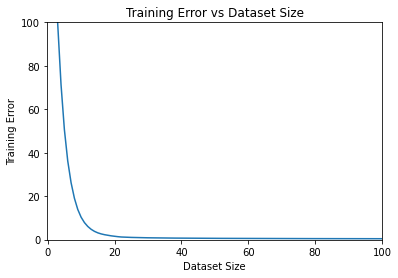

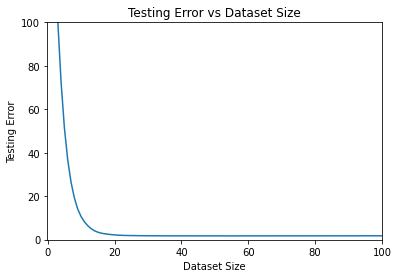

In [80]:
x1, y1 = np.asarray(mseScores_train).T
plt.plot(x1, y1)
plt.title('Training Error vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Training Error')
plt.xlim(-0.1, 100)
plt.ylim(-0.1, 100)
plt.draw()
plt.show()

x2, y2 = np.asarray(mseScores_test).T
plt.plot(x2, y2)
plt.title('Testing Error vs Dataset Size')
plt.xlabel('Dataset Size')
plt.ylabel('Testing Error')
plt.xlim(-0.1, 100)
plt.ylim(-0.1, 100)
plt.draw()
plt.show()

### Bias Variance tradeoff for linear (polynomial) regression with increasing model size (polynomial degree)

#### Using Stochastic Gradient Descent

In [ ]:
# Bias Variance Tradeoff for linear regression using gradient descent
l = [0, 0.5, 1.0]
losses = ["mse", "mae"]

# get the current script path.
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "Bias_Variance_Tradeoff_Regression"

# create your subdirectory
os.mkdir(os.path.join(here, subdir))

for loss in losses:
    for l1 in l:
        for l2 in l:
            mseScores, maeScores, rmseScores, r2Scores = eval_linear (dataset, l1, l2, max_degree = 10, 
                                                                      loss_fn = loss, max_iter = 1e+5)
            filename = "linear_" + loss + "_l1=" + str(l1) + "_l2=" + str(l2) + ".csv"
            filepath = os.path.join(here, subdir, filename)
            file = open (filepath, 'w+', newline = '')
            with file:
                write = writer (file)
                write.writerows(mseScores)
                write.writerow([])
                write.writerows(maeScores)
                write.writerow([])
                write.writerows(rmseScores)
                write.writerow([])
                write.writerows(r2Scores)

#### Using Newton's Method

In [ ]:
 # Training/Test Error for linear regression using newton's method

# get the current script path.
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "Newton_Error_Regression"

# create your subdirectory
#os.mkdir(os.path.join(here, subdir))

mseScores, maeScores, rmseScores, r2Scores = eval_linear (dataset, max_degree = 10, max_iter = 1e+5
                                                          convergence = "Newton's Method")
filename = "newton_errors.csv"
filepath = os.path.join(here, subdir, filename)
file = open (filepath, 'w+', newline = '')
with file:
    write = writer (file)
    write.writerows(mseScores)
    write.writerow([])
    write.writerows(maeScores)
    write.writerow([])
    write.writerows(rmseScores)
    write.writerow([])
    write.writerows(r2Scores)

### Bias Variance tradeoff for classification with increasing model size (polynomial degree)

In [ ]:
# evaluate algorithm
filename = 'bc.csv'
dataset2 = get_csv(filename)
# remove headings
dataset2.remove(dataset2[0]) 
# convert dataset to float columnwise
for i in range(len(dataset2[0])): 
    str_to_float_col(dataset2, i) 

#### Logistic Regression (Stochastic)

In [ ]:
# Bias Variance Tradeoff for logistic regression using gradient descent for classification problem

l = [0, 0.5, 1.0]
losses = ["mse", "mae", "log"]

# get the current script path
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "Bias_Variance_Tradeoff_Classification"

# create your subdirectory
#os.mkdir(os.path.join(here, subdir))

for loss in losses:
    for l1 in l:
        for l2 in l:
            mseScores, maeScores, rmseScores, r2Scores = eval_linear (dataset2, l1, l2, max_degree = 10, 
                                                                      model = "logistic", loss_fn = loss)
            filename = "logistic_" + loss + "_l1=" + str(l1) + "_l2=" + str(l2) + ".csv"
            filepath = os.path.join(here, subdir, filename)
            file = open (filepath, 'w+', newline = '')
            with file:
                write = writer (file)
                write.writerows(mseScores)
                write.writerow([])
                write.writerows(maeScores)
                write.writerow([])
                write.writerows(rmseScores)
                write.writerow([])
                write.writerows(r2Scores)

#### Perceptron Regression (Stochastic)

In [ ]:
l = [0, 0.5, 1.0]

# get the current script path.
here = os.path.dirname(os.path.realpath('__file__'))
subdir = "Bias_Variance_Tradeoff_Classification"

#create your subdirectory
#os.mkdir(os.path.join(here, subdir))

for l1 in l:
    for l2 in l:
        mseScores, maeScores, rmseScores, r2Scores = eval_linear (dataset2, l1, l2, max_degree = 10, 
                                                                  model = "perceptron", loss_fn = "0-1")
        filename = "perceptron_" + "_l1=" + str(l1) + "_l2=" + str(l2) + ".csv"
        filepath = os.path.join(here, subdir, filename)
        file = open (filepath, 'w+', newline = '')
        with file:
            write = writer (file)
            write.writerows(mseScores)
            write.writerow([])
            write.writerows(maeScores)
            write.writerow([])
            write.writerows(rmseScores)
            write.writerow([])
            write.writerows(r2Scores)